# Naive Implementation of a Raycast Renderer

In [1]:
import numpy as np
#import numba as nb
import matplotlib.pyplot as plt

### Minimal Scene Setup

First we will create a very small 3D scene. The scene is made up of objects that we will define later on more precisely. 

First choose the 3D axis representation. For the axis we will use a similar convention to OpenGL, namely

| axis |  name   | negative | positive |
|------|---------|----------|----------|
|    x |  width  |  left    | right    |
|    y | height  |  down    | up       |
|    z |  depth  |  front   | back     |

this axis convention has the convenient property of embeding 2D images in the xy-plane while preserving right-handed coordinates.    

In [2]:
scene = [
    # camera object to render the scene 
    ('Camera', {'x': 0., 'y': 0., 'z': 0.,
                'width': 300, 'height':200,
                'field_of_view': 90., # °
                'focal_length':   .1, # m
               }), 
    
    ## background sphere is seen from the inside
    #('Sphere', {'x': 0., 'y': 0., 'z': -2.0, 'R':15.}),
    
    #foreground spheres are  seen from outside
    ('Sphere', {'x': -1.4, 'y': 0., 'z': -2.5, 'R':1.0, 
                'alb_r': .2, 'alb_g': .3, 'alb_b': .9, 
                'diff': .75, 'spec': .25, 'shininess': 1.2, 
               }),
    ('Sphere', {'x': 0., 'y': 0., 'z': -3.0, 'R':1.0, 
                'alb_r': .2, 'alb_g': .9, 'alb_b': .3, 
                'diff': .25, 'spec': .25, 'shininess': 1.2, 
               }),
    
    ('Sphere', {'x': 1.4, 'y': 0., 'z': -3.5, 'R':1.0, 
                'alb_r': .8, 'alb_g': .9, 'alb_b': .3, 
                'diff': .5, 'spec': .25, 'shininess': 1.2, 
               }),
    
    
    # let there be light!
    ('Light', {'x': 2., 'y': 0., 'z': -1, 
               'amb_r': .4, 'amb_g': .4, 'amb_b': .4,
               'diff_r': 1.0, 'diff_g': 1.0, 'diff_b': 1.0,
               'spec_r': 1.0, 'spec_g': 1.0, 'spec_b': 1.0,
               'brightness': .3 }),
]

### Camera callibration

First of all we will read the camera because this is where the rays start.

In [3]:
#only one camera allowed for now
camera = [ obj for obj in scene if obj[0]=='Camera' ]
assert len(camera) == 1
camera = camera[0][1]

We can construct the inital camera rays by using a trigonometric identity for the pixels

![initial rays](./images/initial_rays.png)


A ray is mathematically a parameterized set constructed appon a supporting point $s \in \mathbb{R}^3$ and directional vector $d \in S^2$ 

$$
    \text{ray}(s,d) = \{ \ s + t \cdot d \ | \ t \geq 0 \}
$$


A pixel $(i,j) \ \in \ \mathbb{Z}_{W \times H} $ casts an initial ray

$$
    s_{ij} = \begin{pmatrix}
    f \ \sin( v )\ \ \Big( \frac{2i}{W-1} - 1\Big) \\
    f \ \sin( v_y )\frac{H}{W} \Big( \frac{2j}{H-1} - 1\Big) \\
    f
    \end{pmatrix}
    \quad \text{and} \quad
    d_{ij} = \frac{s_{ij}}{\|s_{ij}\|}
$$
with camera parameters defined by

- image geometry $W,H \in \mathbb{N}$

- fields of view $0 < v < 90°$

- focal length $f > 0 $ 

In [4]:
def construct_initial_rays(camera):

    #convenient camera parameters 
    W = camera['width']
    H = camera['height']
    v = camera['field_of_view']
    v = np.deg2rad(v)
    f = camera['focal_length']

    #construct rays
    rays = np.zeros((W,H,2,3))

    ii,jj = np.mgrid[:W,:H]
    s = f * np.array([
        np.sin(v)     * (2*ii/(W-1) -1 ),
        np.sin(v)*H/W * (2*jj/(H-1) -1 ),
        -np.ones((W,H)),
    ]).transpose((1,2,0))

    d = s / np.sqrt( np.sum(s**2, axis=2) )[:,:,None] 

    rays[:,:,0,:] = s
    rays[:,:,1,:] = d
    
    return rays

rays = construct_initial_rays(camera)

Now let us have a look at the camera's viewport.

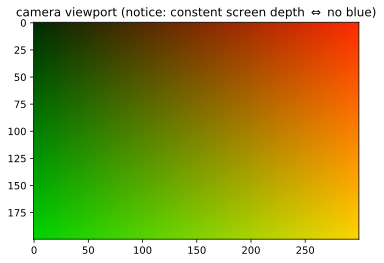

In [5]:
#plot the camera callibration
plt.title('camera viewport (notice: constent screen depth $\Leftrightarrow$ no blue)')
img = rays[:,:,0,:]

M = img.max()
m = img.min()
img = (img-m)/(M-m)
plt.imshow( img[:,:,:].transpose((1,0,2)) )
plt.show()


### Spheres

Now the rays will potentially hit the spherers. To model the rays trajectory through or away from a sphere consider the quadratic radius difference $q$ with

$$ q(t) = \|s + t \cdot d - c \|^2 - R^2  \ 
\begin{cases}
> 0 & \text{no intersections} \\
< 0 & \text{inside the sphere} \\
= 0 & \text{found an intersection}
\end{cases}
$$

with sphere parameters 
- center of the sphere $c = (x,y,z)$ 
- radius $R > 0$

Numerically speaking the case of having exactly one intersection can be neglected. 
The relevant case is when we have two intersections 

![initial rays](./images/ray_intersects_circle.png)

The zeros of $q$ are in fact exactly the parameters for the intersection points. Solving this quadratic formula we get

$$
    q(t) = \alpha t^2 + 2\beta t + \gamma 
    \quad \text{with coefficients}  
$$ 

$$    
    \alpha = \| d \|^2 \quad  
    \beta = \langle d, s-c \rangle \quad
    \gamma = \| s-c \|^2 - R^2
$$

which has zeros 
$$
0 \overset != q(t)  
\quad \Leftrightarrow \quad
t = \frac{-\beta \pm \sqrt{\beta^2 - \alpha \gamma}}{\alpha}
$$

Note that the line the rays lies on intersects in two points with the sphere if and only if $\beta^2 > \alpha \gamma $ holds. Then the intersections with the rays can be calculated by using the points from the intersection with the line as candidates and 

In [6]:
circles = [obj for obj in scene if obj[0]=='Sphere']
circle = circles[0][1]
display(circle)

{'x': -1.4,
 'y': 0.0,
 'z': -2.5,
 'R': 1.0,
 'alb_r': 0.2,
 'alb_g': 0.3,
 'alb_b': 0.9,
 'diff': 0.75,
 'spec': 0.25,
 'shininess': 1.2}

In [7]:
def intersect_rays_with_circle(rays, circle):
    c = np.array( [circle['x'],circle['y'],circle['z']] )
    R = circle['R']

    #quadratic coefficients
    a = np.sum(rays[:,:,1,:]**2, axis=2) #supposed to be unity
    b = np.sum(rays[:,:,1,:] * (rays[:,:,0,:]-c[None,None,:]), axis=2)
    c = np.sum( (rays[:,:,0,:]-c[None,None,:])**2, axis=2 ) - R**2

    #calculate intersection
    intersection = b**2 > a*c
    t = - np.ones(intersection.shape)
    t_back  = np.where(intersection, (-b+np.sqrt( np.maximum(0, b**2-a*c ) + 1e-6))/a, -1 )
    t_front = np.where(intersection, (-b-np.sqrt( np.maximum(0, b**2-a*c )+ 1e-6))/a, -1 )
    t = np.where( intersection & (t_front > 0), t_front, t)
    t = np.where( intersection & (t_front < 0) & (t_back > 0), t_back, t)
    
    return t

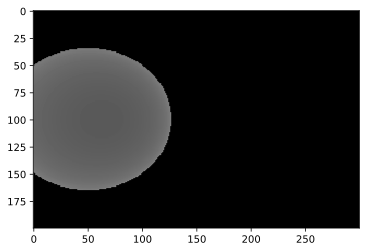

In [8]:
#Render a sphere
img = intersect_rays_with_circle(rays, circle)
plt.imshow( img[:,:].transpose(), cmap='gray', vmin=0.0, vmax=5.0)
plt.show()

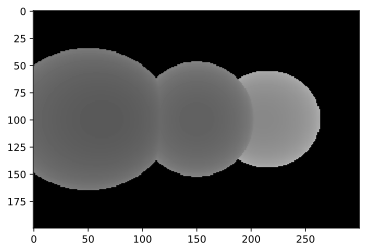

In [9]:
#Render all spheres
depth = -np.ones(rays.shape[:2])
for circle in circles:
    circle = circle[1]
    t = intersect_rays_with_circle(rays, circle)
    
    depth = np.where((t>0) & (depth>0), np.minimum(t, depth), depth)
    depth = np.where((t>0) & (depth<0), t, depth)

img = depth
plt.imshow( img[:,:].transpose(), cmap='gray', vmin=0.0, vmax=5.0)
plt.show()

### Lighting Model

We will use the phong lighting model. It can be described using the shading formula

$$
    I_{\text{render}} = I_{\text{ambient}} + I_{\text{diffuse}}  + I_{\text{specular}} 
$$

where the diffuse intensity models soft shadows and is proportional to the scalar product of normal and the light direction

$$
I_{\text{diffuse}} \sim \langle l , n \rangle 
$$

and the specular intensitiy models highlights and scale with the power of the the scalar product between reflected ray and viewing direction

$$ 
I_{\text{diffuse}} \sim \langle r , v \rangle^\alpha 
\quad \text{with} \quad
r = 2 n \langle n, l \rangle - l 
$$

In [10]:
lights = [obj for obj in scene if obj[0]=='Light']
light = lights[0][1]
display(light)

{'x': 2.0,
 'y': 0.0,
 'z': -1,
 'amb_r': 0.4,
 'amb_g': 0.4,
 'amb_b': 0.4,
 'diff_r': 1.0,
 'diff_g': 1.0,
 'diff_b': 1.0,
 'spec_r': 1.0,
 'spec_g': 1.0,
 'spec_b': 1.0,
 'brightness': 0.3}

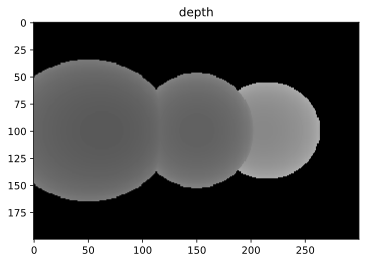

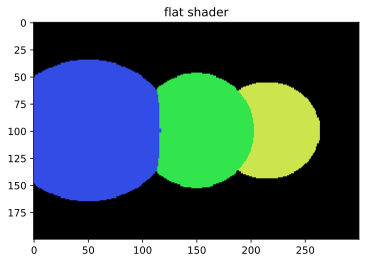

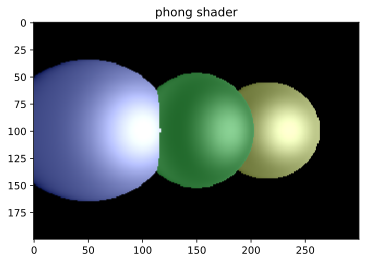

In [11]:
rays = construct_initial_rays(camera)
depth = -np.ones(rays.shape[:2])
flat = np.zeros((*rays.shape[:2], 3))
phong = np.zeros((*rays.shape[:2], 3))

for circle in circles:
    circle = circle[1]
    
    #read constants
    c = np.array( [circle['x'],circle['y'],circle['z']] )
    R = circle['R']
    albedo = np.array( [circle['alb_r'],circle['alb_g'],circle['alb_b']] )
    ambient = np.array( [light['amb_r'],light['amb_g'],light['amb_b']] )
    diffuse = np.array( [light['diff_r'],light['diff_g'],light['diff_b']] )
    specular = np.array( [light['spec_r'],light['spec_g'],light['spec_b']] )
    
    #calculate intersections 
    t = intersect_rays_with_circle(rays, circle)
    mask = (t>0) & ( ((depth>0)&(t<depth)) | (depth<0) ) 
    
    #update depth buffer
    depth = np.where(mask, t, depth)
    
    #update flat shader
    flat = np.where(mask[:,:,None], albedo, flat)

    #update phong shader
    s = rays[:,:,0,:] + t[:,:,None] * rays[:,:,1,:]
    normal = (s - c)/R
    normal = normal / np.sqrt( np.sum(normal**2, axis=2) )[:,:,None] 
    #r = rays[:,:,1,:] - 2 * normal * np.sum( normal*rays[:,:,1,:], axis=2 )[:,:,None]
    
    #quantaties
    l = np.array( [light['x'],light['y'],light['z']] )
    l = s - l[None, None, :]
    distance = np.sqrt( np.sum(l**2, axis=2) )
    l = -l/distance[:,:,None]
    r = 2 * normal * np.sum( normal*l, axis=2 )[:,:,None] - l
    alpha = 2.0
    
    #phong reflection formulas
    color = ambient[None, None,:] * albedo[None, None, :] 
    color = color + circle['diff'] * np.sum( l*normal, axis=2 )[:,:,None]*diffuse[None,None,:]
    
    color = color + circle['spec'] * np.power(np.sum( -r*rays[:,:,1,:], axis=2), alpha)[:,:,None]*specular[None,None,:]
    
    phong = np.where(mask[:,:,None], color, phong)

    
plt.title('depth')
img = depth
plt.imshow( img[:,:].transpose(), cmap='gray', vmin=0.0, vmax=5.0)
plt.show()

plt.title('flat shader')
img = np.maximum( np.minimum(flat, 1.0), 0.0)
plt.imshow( img[:,:, :].transpose((1,0,2)) )
plt.show()

plt.title('phong shader')
img = np.maximum( np.minimum(phong, 1.0), 0.0)
plt.imshow( img[:,:, :].transpose((1,0,2)) )
plt.show()